In [66]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

In [67]:
#MNIST Dataset Download
mnist_train = dsets.MNIST(root = './', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = dsets.MNIST(root = './', train=False, transform=transforms.ToTensor(), download=True)

In [68]:
mnist_train.data.shape

torch.Size([60000, 28, 28])

In [69]:
#pytorch - 데이터로더 : 미니배치학습, 셔플, 병렬처리까지 수행할 수 있도록 하는 기능
data_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size = 256, shuffle=True, drop_last=True)

In [70]:
class CNN_torch(torch.nn.Module):

  def __init__(self):
    super(CNN_torch, self).__init__()

    #layer 1
    self.layer_1 = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )

    #layer2
    self.layer_2 = torch.nn.Sequential(
        torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )

    #전결합층 7*7*64 = layer_2에서 out으로 나온 shape = (?, 7, 7, 64)
    self.fc = torch.nn.Linear(7*7*64, 10, bias=True)

    #전결합층 한정으로 가중치 초기화
    torch.nn.init.xavier_uniform_(self.fc.weight)


  def forward(self, x):

    out = self.layer_1(x)
    out = self.layer_2(out)
    out = out.view(out.size(0), -1) #전결합층을 위한 flatten
    out = self.fc(out)

    return out

In [71]:
#Model
# model = CNN_torch()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN_torch().to(device)  #.to(device) : 텐서 연산 시 모든 텐서가 동일한 operation(cpu, gpu)를 사용하게 하기 위함

In [72]:
criterion = torch.nn.CrossEntropyLoss().to(device)  #비용함수에 소프트맥스 함수 포함
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [73]:
total_batch = len(data_loader)
print(f'총 배치 수 : {total_batch}')

총 배치 수 : 234


In [74]:
#Training
training_epochs = 15

for epoch in range(training_epochs):
  avg_cost = 0

  for X, Y in data_loader:  #데이터로더로 만든 미니배치 단위로 꺼내옴
    X = X.to(device)
    Y = Y.to(device)

    #pytorch는 gradients 값들을 추후에 backward 해줄때 계속 더해주기 때문에, 항상 zero로 만들어 주고 시작을 해야함. 한번의 학습이 완료되면 0으로 초기화
    #미분을 통해 얻은 기울기를 0으로 초기화. 기울기를 초기화 해야만 새로운 가중치 편향에 대해 새로운 기울기를 구할 수 있음
    optimizer.zero_grad()

    hypothesis = model(X)  #W(가중치), b(편향)에 대한 가설 생성
    cost = criterion(hypothesis, Y)  #가설에 대한 cost(예측-실제) 계산
    cost.backward() #W(가중치), b(편향)에 대한 gradient(기울기) 계산
    optimizer.step() #최적화 하여 W,b 업데이트

    avg_cost += cost/total_batch
  print(f'[Epoch : {epoch+1}], cost = {avg_cost}')


[Epoch : 1], cost = 0.3605680465698242
[Epoch : 2], cost = 0.08025528490543365
[Epoch : 3], cost = 0.05856094881892204


KeyboardInterrupt: ignored

In [25]:
#Test
#torch.no_grad() - 더이상 자동으로 gradient를 트래킹하지 않음
#loss.backward()를 안한다면 gradient를 계산해도 업데이트 되지 않기는 함
#하지만 autograd를 끔으로써 메모리 사용량을 줄이고 연산 속도를 높일 수 있다.
with torch.no_grad():
  X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
  Y_test = mnist_test.test_labels.to(device)

  pred = model(X_test)
  correct_pred = torch.argmax(pred, 1) == Y_test
  accuracy = correct_pred.float().mean()
  print(f'Accuracy : {accuracy.item()}')

Accuracy : 0.9845999479293823


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


# **Layer 더 쌓아보기**

In [81]:
class CNN_Model_deep(torch.nn.Module):

  def __init__(self):
    super(CNN_Model_deep, self).__init__()

    self.keep_prob = 0.5

    #layer 1
    self.layer_1 = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )

    #layer 2
    self.layer_2 = torch.nn.Sequential(
        torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2)
    )

    #layer 3
    self.layer_3 = torch.nn.Sequential(
        torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
    )

    #layer 4
    self.fc_1 = torch.nn.Linear(4*4*128, 625, bias=True)  #4*4*128 = 625
    torch.nn.init.xavier_uniform_(self.fc_1.weight)  #fc_1 layer 가중치 초기화
    self.layer_4 = torch.nn.Sequential(
        self.fc_1,
        torch.nn.ReLU(),
        torch.nn.Dropout(p=1 - self.keep_prob)
    )

    self.fc_2 = torch.nn.Linear(625, 10, bias=True)
    torch.nn.init.xavier_uniform_(self.fc_2.weight)


  def forward(self, x):

    out = self.layer_1(x)
    out = self.layer_2(out)
    out = self.layer_3(out)
    out = out.view(out.size(0),-1) #flatten
    out = self.layer_4(out)
    out = self.fc_2(out)

    return out

In [82]:
#Model
model = CNN_Model_deep().to(device)

In [83]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [84]:
print(f'총 배치 수 : {total_batch}')

총 배치 수 : 234


In [85]:
#TRAIN
training_epochs = 15

for epoch in range(training_epochs):
  avg_cost =0

  for X, Y in data_loader:
    X = X.to(device)
    Y = Y.to(device)

    optimizer.zero_grad()  #훈련마다 optimizer의 초기 gradient를 0으로 세팅
    hypothesis = model(X)  #가설 생성, (W,b 생성)
    cost = criterion(hypothesis, Y) #가설과 실제 값을 비교하여 cost 계산
    cost.backward() #W, b에 대한 gradient 계산
    optimizer.step() #최적화를 통한 W, b 업데이트

    avg_cost += cost / total_batch
  print(f'[Epoch : {epoch+1}], cost = {avg_cost}')

[Epoch : 1], cost = 0.27768033742904663
[Epoch : 2], cost = 0.060227084904909134
[Epoch : 3], cost = 0.042431000620126724
[Epoch : 4], cost = 0.03298079967498779
[Epoch : 5], cost = 0.026003606617450714
[Epoch : 6], cost = 0.022383859381079674
[Epoch : 7], cost = 0.01982288435101509
[Epoch : 8], cost = 0.017237745225429535
[Epoch : 9], cost = 0.014102503657341003
[Epoch : 10], cost = 0.013518491759896278
[Epoch : 11], cost = 0.013304460793733597
[Epoch : 12], cost = 0.010769808664917946
[Epoch : 13], cost = 0.009903808124363422
[Epoch : 14], cost = 0.008512440137565136
[Epoch : 15], cost = 0.009614041075110435


In [86]:
with torch.no_grad():
  X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
  Y_test = mnist_test.test_labels.to(device)

  pred = model(X_test)
  correct_pred = torch.argmax(pred, 1) == Y_test
  accuracy = correct_pred.float().mean()
  print(f'Accuracy : {accuracy.item()}')

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy : 0.9901999831199646


In [87]:
pred_label = torch.argmax(pred, 1)

In [92]:
print(f'X_test len : {X_test.shape}')
print(f'pred_label len : {pred_label.shape}')

X_test len : torch.Size([10000, 1, 28, 28])
pred_label len : torch.Size([10000])


In [93]:
X_test_reshape = X_test.view(len(X_test), 28, 28, 1)

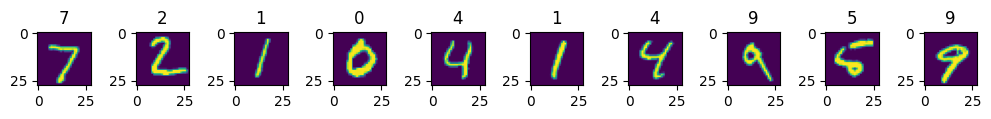

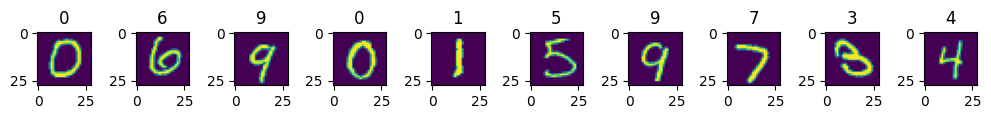

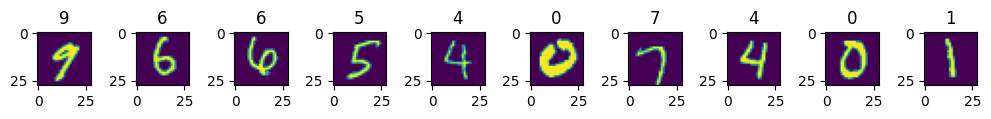

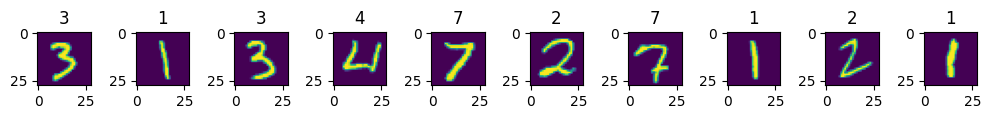

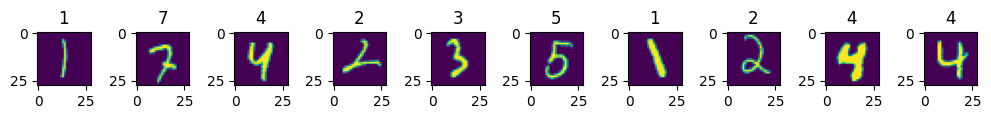

In [123]:
import matplotlib.pyplot as plt

imgs_list = []
preds_list = []
for i in range(50):
  if i == 0 :
    imgs = []
    preds = []
    imgs.append(X_test_reshape[i].cpu())
    preds.append(pred_label[i])
  elif i%10 == 0:
    imgs_list.append(imgs)
    preds_list.append(preds)
    imgs = []
    preds = []
    imgs.append(X_test_reshape[i].cpu())
    preds.append(pred_label[i])
  else:
    imgs.append(X_test_reshape[i].cpu())
    preds.append(pred_label[i])
imgs_list.append(imgs)
preds_list.append(preds)


for imgs, preds in zip(imgs_list, preds_list):
  fig = plt.figure(figsize=(10,5))
  cnt = 0
  for img, pred in zip(imgs, preds):
    ax = fig.add_subplot(1,10,cnt+1)
    ax.imshow(img)
    ax.set_title(f'{pred}')
    cnt+=1
  plt.tight_layout()
  plt.show()

In [119]:
1%10

1